In [2]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/1006')
print(os.getcwd())

/content
/content/drive/My Drive/1006


In [5]:
import pandas as pd
import numpy as np

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
data = pd.read_csv('eo_cvec_nmf16_train.csv', index_col=0)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,0.000000,0.000000,0.403011,0.000000,0.000000,0.000000,3.205941,0.110752,0.000000,0.00000,0.188705,0.032379,0.000000,1.072802
1,0.000000,0.000000,0.459963,0.027324,0.000000,0.004531,0.000000,0.000000,0.000000,0.000000,0.025243,0.00000,0.080065,0.000000,0.000000,0.000000
2,0.023295,0.000571,0.000000,0.475547,0.039414,0.000000,0.000000,0.000000,0.008591,0.000000,0.000000,0.00000,0.196411,0.000000,0.000000,0.051880
3,0.023184,0.010252,0.085706,0.390665,0.000000,0.000467,0.000000,0.004906,0.000000,0.000000,0.000000,0.01187,0.138094,0.008015,0.011307,0.100273
4,0.516222,0.000000,0.000000,0.044462,0.000315,0.000000,0.020246,0.184139,0.000000,3.106058,0.000000,0.00000,0.000000,0.475770,1.330581,1.211706


In [8]:
data = torch.tensor(data.values)
data = data.T
print(data.shape)
data = data.to(device)
#max_data = torch.max(data)
#min_data = torch.min(data)
#data = (data - min_data) / (max_data - min_data)
data

torch.Size([16, 8437])


tensor([[0.0000e+00, 0.0000e+00, 2.3295e-02,  ..., 0.0000e+00, 5.5637e-02,
         2.6726e-01],
        [0.0000e+00, 0.0000e+00, 5.7106e-04,  ..., 7.5989e-05, 9.3464e-05,
         0.0000e+00],
        [0.0000e+00, 4.5996e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.1099e+00],
        ...,
        [3.2379e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7022e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9474e-02, 1.0459e-03,
         0.0000e+00],
        [1.0728e+00, 0.0000e+00, 5.1880e-02,  ..., 0.0000e+00, 6.4706e-02,
         1.7601e-01]], device='cuda:0', dtype=torch.float64)

In [9]:
class SparseModel(nn.Module):
  def __init__(self, hdim):
    super(SparseModel, self).__init__()
    self.hdim = hdim
    w = torch.zeros((hdim, hdim))
    torch.nn.init.xavier_normal_(w)
    w.requires_grad = True
    self.weights = nn.Parameter(w)

  def forward(self, input):
    x = torch.matmul(input, self.weights)
    return x

def custom_loss(output, input):
  return 0.5 * torch.square(torch.norm(input-output, p='fro')) / input.size()[1]

In [10]:
learning_rate = 0.005
num_epochs = 20000
lmbda = 0.01

In [11]:
model = SparseModel(data.size()[1]).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_list = []
prev_eval_loss = 99999
for epoch in range(num_epochs):
  model.train()
  # ===================forward=====================
  output = model(data.float())
  reg21 = torch.sum(torch.norm(model.weights, p=2, dim=1))
  loss = custom_loss(output, data) + lmbda * reg21
  print('L1 norm of L2 norm of weights: ', reg21.item())
  # ===================backward====================
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # ===================log=======================
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
  model.eval()
  eval_loss = F.l1_loss(model(data.float()), data.float()).item()
  loss_list.append(eval_loss)
  print('Eval loss: ', eval_loss)
  if eval_loss > prev_eval_loss:
    break
  prev_eval_loss = eval_loss
#torch.save(model.state_dict(), './sim_autoencoder.pth')

Streaming output truncated to the last 5000 lines.
epoch [8995/20000], loss:46.5066
Eval loss:  0.020555412396788597
L1 norm of L2 norm of weights:  4648.009765625
epoch [8996/20000], loss:46.5024
Eval loss:  0.020554151386022568
L1 norm of L2 norm of weights:  4647.5888671875
epoch [8997/20000], loss:46.4982
Eval loss:  0.02055288664996624
L1 norm of L2 norm of weights:  4647.1689453125
epoch [8998/20000], loss:46.4940
Eval loss:  0.02055162750184536
L1 norm of L2 norm of weights:  4646.74853515625
epoch [8999/20000], loss:46.4898
Eval loss:  0.02055036649107933
L1 norm of L2 norm of weights:  4646.328125
epoch [9000/20000], loss:46.4856
Eval loss:  0.0205491092056036
L1 norm of L2 norm of weights:  4645.9072265625
epoch [9001/20000], loss:46.4814
Eval loss:  0.02054784819483757
L1 norm of L2 norm of weights:  4645.4873046875
epoch [9002/20000], loss:46.4772
Eval loss:  0.02054659277200699
L1 norm of L2 norm of weights:  4645.06640625
epoch [9003/20000], loss:46.4730
Eval loss:  0.020

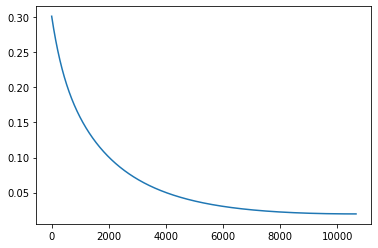

In [13]:
plt.plot(loss_list)

In [12]:
print(data)
res = model(data.float()).cpu().detach()
print(res)

tensor([[0.0000e+00, 0.0000e+00, 2.3295e-02,  ..., 0.0000e+00, 5.5637e-02,
         2.6726e-01],
        [0.0000e+00, 0.0000e+00, 5.7106e-04,  ..., 7.5989e-05, 9.3464e-05,
         0.0000e+00],
        [0.0000e+00, 4.5996e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.1099e+00],
        ...,
        [3.2379e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7022e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9474e-02, 1.0459e-03,
         0.0000e+00],
        [1.0728e+00, 0.0000e+00, 5.1880e-02,  ..., 0.0000e+00, 6.4706e-02,
         1.7601e-01]], device='cuda:0', dtype=torch.float64)
tensor([[ 1.5664e-02,  2.1417e-02,  2.0061e-02,  ...,  8.8515e-03,
          6.5983e-02,  2.0405e-01],
        [ 4.5573e-04,  1.2588e-04,  4.3468e-04,  ...,  4.6749e-04,
         -9.1834e-05,  2.2479e-05],
        [-6.0839e-03,  4.0305e-01,  1.7006e-02,  ...,  1.3067e-02,
          1.7664e-02,  1.0010e+00],
        ...,
        [ 1.9998e-01,  6.6037e-04, -1.6970e-

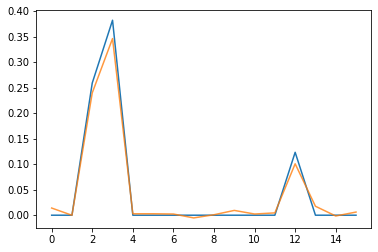

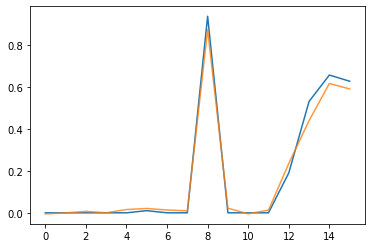

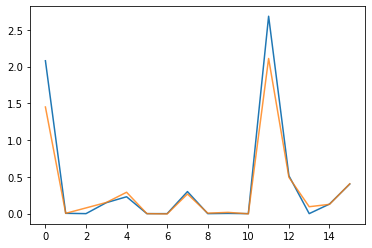

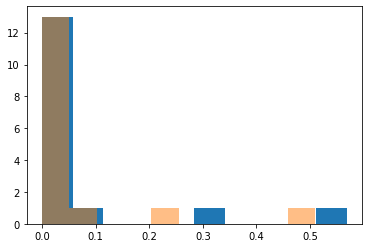

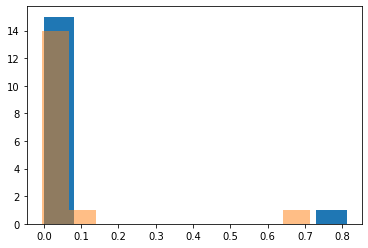

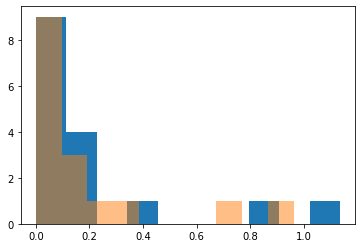

In [14]:
plt.plot(data[:,1998].detach().cpu())
plt.plot(res[:,1998], alpha=0.8)
plt.show()
plt.plot(data[:,113].detach().cpu())
plt.plot(res[:,113], alpha=0.8)
plt.show()
plt.plot(data[:,4567].detach().cpu())
plt.plot(res[:,4567], alpha=0.8)
plt.show()
plt.hist(data[:,5698].detach().cpu())
plt.hist(res[:,5698], alpha=0.5)
plt.show()
plt.hist(data[:,123].detach().cpu())
plt.hist(res[:,123], alpha=0.5)
plt.show()
plt.hist(data[:,4444].detach().cpu())
plt.hist(res[:,4444], alpha=0.5)
plt.show()

In [23]:
mw = model.weights.cpu().detach()
np.save('indices_eo_cvec_nmf16_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

| Embedding type | learning rate | lambda |
| --- | --- | --- |
| cvec_tsne16 | 0.0005 | 0.1 |
| cvec_pca16 | 0.0005 | 0.1 |
| cvec_umap16 | 0.0005 | 0.1 |
| cvec_nmf16 | 0.005 | 0.01 |
| bert | 0.01 | 0.01 |
| distil | 0.01 | 0.01 |
| roberta | 0.01 | 0.01 |
| glove6B | 0.01 | 0.01 |
| universal | 0.05 | 0.001 |